In [1]:
%load_ext autoreload
%autoreload 2

from interface import *
from matplotlib import pyplot as plt
from pangolin.interface import *
from pangolin import new_infer as infer

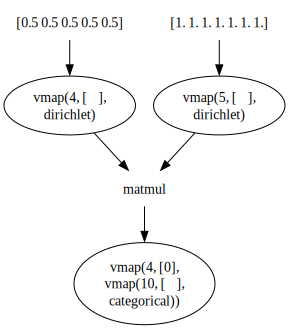

skipping MCMC...


In [2]:
# topics integrated out, word outputs

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
p = θ @ φ # M x V matrix: p[m,v] is prob of getting word v in document m
w = plate(p)(lambda p_m:
             plate(N=N)(lambda:
                        categorical(p_m)))
display(viz_upstream(w))
ws = infer.sample(w,niter=1)
assert ws[0].shape == (M, N)

skipping MCMC...


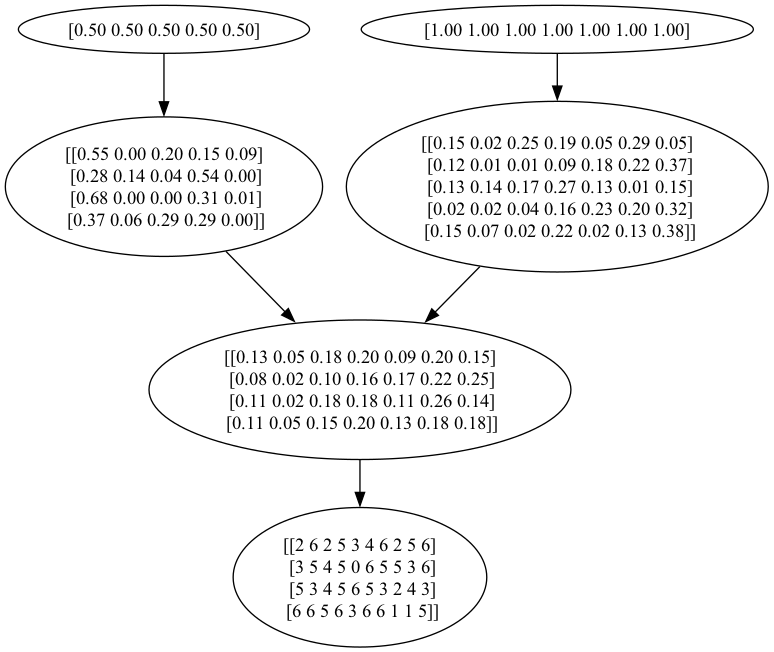

In [3]:
viz_samples_live(w)

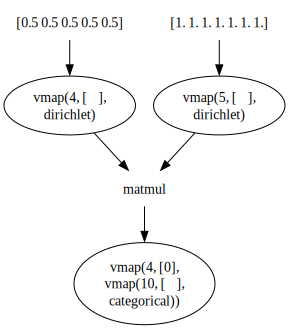

skipping MCMC...


In [4]:
# topics integrated out, word count outputs

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(np.ones(K))
β = makerv(np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
p = θ @ φ # M x V matrix: p[m,v] is prob of getting word v in document m
c = plate(p)(lambda p_m:
            multinomial(N, p_m))
display(viz_upstream(w))
cs = infer.sample(c,niter=1)
assert cs[0].shape == (M, V)

skipping MCMC...


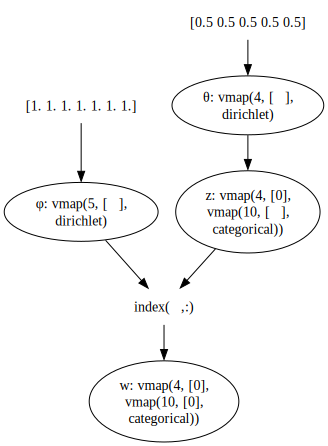

In [5]:
# explicitly construct topics

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(1*np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
z = plate(θ)(lambda θ_m:
             plate(N=N)(lambda:
                        categorical(θ_m)))
assert z.shape == (M,N) # each entry of z is between 0 and K
φz = φ[z]
assert φz.shape == (M,N,V)

w = plate(φz)(lambda φz_m:
              plate(φz_m)(lambda φz_mn:
                          categorical(φz_mn)))

assert w.shape == (M,N)

αs, θs, zs, ws = infer.sample((α,θ,z,w),niter=1)

viz_upstream(w,[],{θ:'θ',φ:'φ',z:'z',w:'w'})

skipping MCMC...


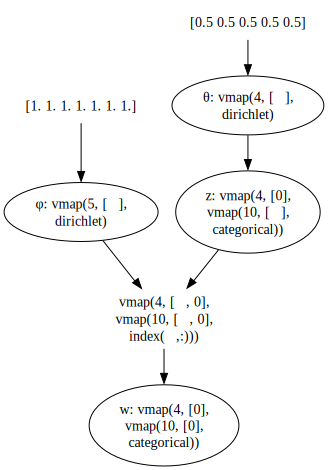

In [6]:
# explicitly construct topics and words in same plate structure

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(1*np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
z, w = plate(θ)(lambda θ_m:
             plate(N=N)(lambda:
                        (z_mn := categorical(θ_m),
                         w_mn := categorical(φ[z_mn]))))

assert z.shape == (M,N)
assert w.shape == (M,N)

αs, θs, zs, ws = infer.sample((α,θ,z,w),niter=1)

viz_upstream(w,[],{θ:'θ',φ:'φ',z:'z',w:'w'})

is there a simpler version of this "matrix multiply to integrate out categorical" operation?

Sure. Of course.

* All that's *really* happening here seems to be: In general you can integrate out discrete latent variables to get a mixture. But *here* that mixture happens to have a closed form because a mixture of categorical distributions is still a categorical distribution.

skipping MCMC...


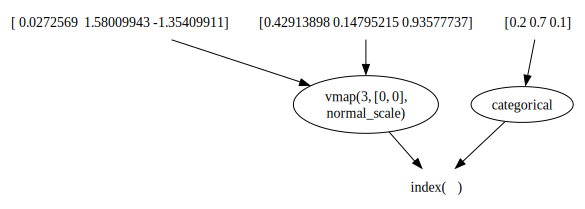

In [7]:
locs = makerv(np.random.randn(3))
scales = makerv(np.abs(np.random.randn(3)))
a = vmap(normal,0)(locs,scales)
i = categorical([.2,.7,.1])
x = a[i]
xs = infer.sample(x,niter=1000000)
np.mean(xs)
viz_upstream(x)

skipping MCMC...


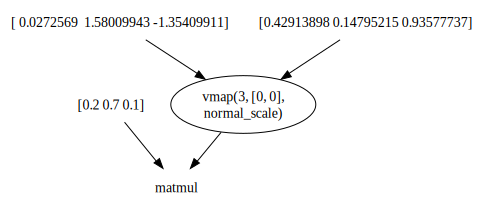

In [8]:
a = vmap(normal,0)(locs,scales)
Ex = makerv([.2,.7,.1]) @ a
Exs = infer.sample(Ex,niter=1000000)
np.mean(Exs)
viz_upstream(Ex)